In [14]:
!pip install PyDrive
!pip install pydicom
!pip install h5py

In [15]:
from google.colab import drive
drive.mount('/content/Gdrive')

Drive already mounted at /content/Gdrive; to attempt to forcibly remount, call drive.mount("/content/Gdrive", force_remount=True).


In [16]:
cd /content/Gdrive/My Drive/LIDC-IDRI2/

/content/Gdrive/My Drive/LIDC-IDRI2


In [17]:
import cell_magic_wand as cmw
import numpy as np
import pandas as pd 
import pydicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
from skimage import measure, morphology
from sklearn.cluster import KMeans
from skimage.transform import resize
from skimage.draw import circle
!python 'cell_magic_wand.py'

#File paths
dir= '/content/Gdrive/My Drive/LIDC-IDRI/'
metadatapath=dir+"LIDC-IDRI_MetaData.csv"
list32path=dir+"list3.2.csv"
DOIfolderpath=dir+'Dataset/'
datafolder=dir+'ProcessedData'

#Load metadata
meta=pd.read_csv(metadatapath)
meta=meta.drop(meta[meta['Modality']!='CT'].index)
meta=meta.reset_index()

ModuleNotFoundError: ignored

In [ ]:
!apt-get -qq install cell_magic_wand

E: Unable to locate package cell_magic_wand


In [ ]:
#Get folder names of CT data for each patient
patientsIndex=[DOIfolderpath+meta['Patient Id'][i] for i in range(len(meta))]
dataPatients = []
for i in range(0,len(meta)-1):
  for path in os.listdir(patientsIndex[i]):
    if os.path.exists(patientsIndex[i]+'/'+path+'/'+meta['Series UID'][i]):
      dataPatients.append(patientsIndex[i]+'/'+path+'/'+meta['Series UID'][i])
patientsData=dataPatients
print(patientsData)

['/content/Gdrive/My Drive/LIDC-IDRI/Dataset/LIDC-IDRI-0001/1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288633453246975630178/1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636438705059720603192', '/content/Gdrive/My Drive/LIDC-IDRI/Dataset/LIDC-IDRI-0002/1.3.6.1.4.1.14519.5.2.1.6279.6001.490157381160200744295382098329/1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417051974713149104919', '/content/Gdrive/My Drive/LIDC-IDRI/Dataset/LIDC-IDRI-0003/1.3.6.1.4.1.14519.5.2.1.6279.6001.101370605276577556143013894866/1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615202213033480003264', '/content/Gdrive/My Drive/LIDC-IDRI/Dataset/LIDC-IDRI-0004/1.3.6.1.4.1.14519.5.2.1.6279.6001.191425307197546732281885591780/1.3.6.1.4.1.14519.5.2.1.6279.6001.323541312620128092852212458228', '/content/Gdrive/My Drive/LIDC-IDRI/Dataset/LIDC-IDRI-0005/1.3.6.1.4.1.14519.5.2.1.6279.6001.190188259083742759886805142125/1.3.6.1.4.1.14519.5.2.1.6279.6001.129007566048223160327836686225', '/content/Gdrive/My Drive/LIDC-IDRI/Dataset/

In [ ]:
#Load nodules locations
nodulelocations=pd.read_csv(list32path)

In [ ]:
# Load the scans in given folder path
def load_scan(path):
    slices = [pydicom.read_file(path + '/' + s, force=True) for s in os.listdir(path) if s.endswith('.dcm')]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]), reverse=True)
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [ ]:
#convert to ndarray
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None
    
def segment_lung_mask(image, fill_lung_structures=True, dilate=False):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures==True:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
    
    if dilate==True:
        for i in range(binary_image.shape[0]):
            binary_image[i]=morphology.dilation(binary_image[i],np.ones([10,10]))
    return binary_image

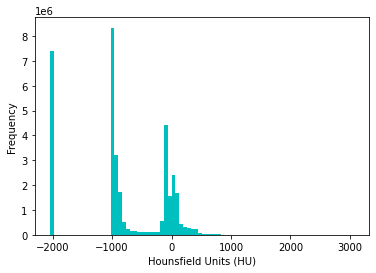

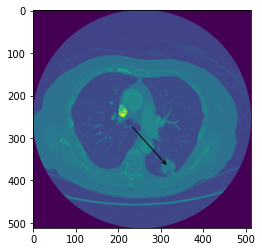

In [ ]:
#Let's look at one of the patients

first_patient = load_scan(patientsData[0])
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

import scipy
# Show some slice in the middle
#data=scipy.ndimage.interpolation.zoom(first_patient_pixels[41],[200,200])
plt.figure()
plt.imshow(first_patient_pixels[42])
plt.annotate('', xy=(317, 367), xycoords='data',
             xytext=(0.5, 0.5), textcoords='figure fraction',
             arrowprops=dict(arrowstyle="->"))
#plt.savefig("images/test.png",dpi=300)
plt.show()

In [ ]:
def processimage(img):
    #Standardize the pixel values
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    #plt.hist(img.flatten(),bins=200)
    #plt.show()
    #print(thresh_img[366][280:450])
    middle = img[100:400,100:400] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    #move the underflow bins
    img[img==max]=mean
    img[img==min]=mean
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image
    eroded = morphology.erosion(thresh_img,np.ones([4,4]))
    dilation = morphology.dilation(eroded,np.ones([10,10]))
    labels = measure.label(dilation)
    label_vals = np.unique(labels)
    #plt.imshow(labels)
    #plt.show()
    labels = measure.label(dilation)
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<475 and B[3]-B[1]<475 and B[0]>40 and B[2]<472:
            good_labels.append(prop.label)
    mask = np.ndarray([512,512],dtype=np.int8)
    mask[:] = 0
    #
    #  The mask here is the mask for the lungs--not the nodes
    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    #
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation
    return mask*img

def nodule_coordinates(nodulelocations,meta):
    slices=nodulelocations["slice no."][nodulelocations.index[nodulelocations["case"]==int(meta["Patient Id"][-4:])]]
    xlocs=nodulelocations["x loc."][nodulelocations.index[nodulelocations["case"]==int(meta["Patient Id"][-4:])]]
    ylocs=nodulelocations["y loc."][nodulelocations.index[nodulelocations["case"]==int(meta["Patient Id"][-4:])]]
    nodulecoord=[]
    for i in range(len(slices)):
        nodulecoord.append([slices.values[i]-1,xlocs.values[i]-1,ylocs.values[i]-1])
    return nodulecoord

In [ ]:
noduleimages=np.ndarray([len(nodulelocations)*3,512,512],dtype=np.float32)
nodulemasks=np.ndarray([len(nodulelocations)*3,512,512],dtype=np.bool)
nodulemaskscircle=np.ndarray([len(nodulelocations)*3,512,512],dtype=np.bool)
index=0
totaltime=50000
start_time=time.time()
elapsed_time=0
nodulemeanhu=[]
nonnodulemeanhu=[]
thresh=-500
for i in range(len(patientsData)):
    print("Processing patient#",i,"ETA:",(totaltime-elapsed_time)/3600,"hrs")
    coord=nodule_coordinates(nodulelocations,meta.iloc[i])
    if len(coord)>0:
        patient=load_scan(patientsData[i])
        patient_pix=get_pixels_hu(patient)
        radius=nodulelocations["eq. diam."][nodulelocations.index[nodulelocations["case"]==int(meta["Patient Id"][i][-4:])]]
        nodulemask=np.ndarray([len(coord),512,512],dtype=np.bool)
        for j,cord in enumerate(coord):
            segmented_mask_fill=segment_lung_mask(patient_pix,True,False)
            if radius.iloc[j]>5:
                #slice nodulecenter-1
                noduleimages[index]=processimage(patient_pix[cord[0]-1])
                nodulemasks[index]=cmw.cell_magic_wand(-patient_pix[int(cord[0])-1],[int(cord[2]),int(cord[1])],2,int(radius.iloc[j])+2)
                rr,cc=circle(int(cord[2]),int(cord[1]),int(radius.iloc[j]))
                imgcircle = np.zeros((512, 512), dtype=np.int16)
                imgcircle[rr,cc]=1
                nodulepixcircle=imgcircle*patient_pix[cord[0]-1]
                nodulepixcircle[nodulepixcircle<thresh]=0
                nodulepixcircle[nodulepixcircle!=0]=1
                nodulemaskscircle[index]=nodulepixcircle.astype(np.bool)
                
                nodulepix=nodulemasks[index]*patient_pix[cord[0]-1]
                nodulepix[nodulepix<thresh]=0
                nodulepix[nodulepix!=0]=1
                nodulemasks[index]=nodulepix.astype(np.bool)
                index+=1
                
                #slice nodulecenter
                noduleimages[index]=processimage(patient_pix[cord[0]])
                nodulemasks[index]=cmw.cell_magic_wand(-patient_pix[int(cord[0])],[int(cord[2]),int(cord[1])],2,int(radius.iloc[j])+2)
                nodulepix=nodulemasks[index]*patient_pix[cord[0]]
                nodulepix[nodulepix<thresh]=0
                nodulepixcircle=imgcircle*patient_pix[cord[0]]
                nodulepixcircle[nodulepixcircle<thresh]=0
                
                #get mean nodule HU value

                #get mean non-nodule HU value
                nonnodule=(nodulemasks[index].astype(np.int16)-1)*-1*segmented_mask_fill[cord[0]]*patient_pix[cord[0]]
                nonnodule[nonnodule<thresh]=0
                nonnodulemeanhu.append(np.mean(nonnodule[nonnodule!=0]))
                # plt.figure()
                # #plt.hist(nodulepix[nodulepix!=0].flatten(),bins=80, alpha=0.5, color='blue')
                # plt.hist(nonnodule[nonnodule!=0].flatten(),bins=80, alpha=0.5, color='orange')
                # plt.hist(nodulepixcircle[nodulepix!=0].flatten(),bins=80,alpha=0.5, color='green')
                # plt.savefig("histplots/"+meta['Patient Id'].loc[i]+"slice"+str(cord)+".png",dpi=300)
                plt.close()
                nodulemeanhu.append(np.mean(nodulepix[nodulepix!=0]))
                nodulepix[nodulepix!=0]=1
                nodulemasks[index]=nodulepix.astype(np.bool)
                nodulepixcircle[nodulepixcircle!=0]=1
                nodulemaskscircle[index]=nodulepixcircle.astype(np.bool)
                index+=1
                
                #slice nodulecenter+1
                noduleimages[index]=processimage(patient_pix[cord[0]+1])
                nodulemasks[index]=cmw.cell_magic_wand(-patient_pix[int(cord[0])+1],[int(cord[2]),int(cord[1])],2,int(radius.iloc[j])+2)
                nodulepix=nodulemasks[index]*patient_pix[cord[0]+1]
                nodulepix[nodulepix<thresh]=0
                nodulepix[nodulepix!=0]=1
                nodulemasks[index]=nodulepix.astype(np.bool)
                nodulepixcircle=imgcircle*patient_pix[cord[0]+1]
                nodulepixcircle[nodulepixcircle<thresh]=0
                nodulepixcircle[nodulepixcircle!=0]=1
                nodulemaskscircle[index]=nodulepixcircle.astype(np.bool)
                index+=1
    elapsed_time=time.time()-start_time
    totaltime=elapsed_time/(i+1)*len(patientsData)


Processing patient# 0 ETA: 13.88888888888889 hrs
Processing patient# 1 ETA: 0.8759840674532784 hrs
Processing patient# 2 ETA: 3.998841082983547 hrs
Processing patient# 3 ETA: 4.72053497493267 hrs
Processing patient# 4 ETA: 5.237952325476541 hrs
Processing patient# 5 ETA: 5.153817640476757 hrs
Processing patient# 6 ETA: 5.399383226831754 hrs
Processing patient# 7 ETA: 5.315648823692684 hrs
Processing patient# 8 ETA: 5.363929430246353 hrs
Processing patient# 9 ETA: 5.8589107394218445 hrs
Processing patient# 10 ETA: 6.266145057015949 hrs
Processing patient# 11 ETA: 6.534569596028088 hrs
Processing patient# 12 ETA: 6.879870847066243 hrs
Processing patient# 13 ETA: 6.7653242414884085 hrs
Processing patient# 14 ETA: 6.496365439522834 hrs
Processing patient# 15 ETA: 6.43111747390694 hrs
Processing patient# 16 ETA: 6.466254952251911 hrs
Processing patient# 17 ETA: 6.4796113275702485 hrs


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **

Processing patient# 18 ETA: 6.411552458383418 hrs
Processing patient# 19 ETA: 6.504218865831693 hrs
Processing patient# 20 ETA: 6.514290254513423 hrs
Processing patient# 21 ETA: 6.468090754605474 hrs
Processing patient# 22 ETA: 6.343793429931005 hrs
Processing patient# 23 ETA: 6.223182980864521 hrs
Processing patient# 24 ETA: 6.180830382936531 hrs
Processing patient# 25 ETA: 6.204006845288807 hrs


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Processing patient# 26 ETA: 6.247613877165012 hrs
Processing patient# 27 ETA: 6.263926253672 hrs
Processing patient# 28 ETA: 6.018100460786669 hrs
Processing patient# 29 ETA: 6.045551382058882 hrs
Processing patient# 30 ETA: 5.948776543140411 hrs
Processing patient# 31 ETA: 5.934960653104662 hrs
Processing patient# 32 ETA: 5.728135144164165 hrs
Processing patient# 33 ETA: 5.66549541566107 hrs
Processing patient# 34 ETA: 5.6815054153539 hrs
Processing patient# 35 ETA: 5.597115523285336 hrs
Processing patient# 36 ETA: 5.653574329261427 hrs
Processing patient# 37 ETA: 5.603471267597453 hrs
Processing patient# 38 ETA: 5.52339338562642 hrs
Processing patient# 39 ETA: 5.67398792263789 hrs
Processing patient# 40 ETA: 5.625950140323904 hrs
Processing patient# 41 ETA: 5.59394955641532 hrs
Processing patient# 42 ETA: 5.635665380254625 hrs


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Processing patient# 43 ETA: 5.578930987590968 hrs
Processing patient# 44 ETA: 5.564354723150079 hrs
Processing patient# 45 ETA: 5.647974670264456 hrs
Processing patient# 46 ETA: 5.655349101608502 hrs
Processing patient# 47 ETA: 5.582185726746318 hrs
Processing patient# 48 ETA: 5.647564356327057 hrs
Processing patient# 49 ETA: 5.743812441187921 hrs
Processing patient# 50 ETA: 5.676521186365021 hrs
Processing patient# 51 ETA: 5.6296375449342655 hrs
Processing patient# 52 ETA: 5.677882596274727 hrs
Processing patient# 53 ETA: 5.6222319911286025 hrs
Processing patient# 54 ETA: 5.559750040357495 hrs
Processing patient# 55 ETA: 5.565816824646911 hrs
Processing patient# 56 ETA: 5.581416531257213 hrs
Processing patient# 57 ETA: 5.559628693398676 hrs
Processing patient# 58 ETA: 5.511717890930359 hrs
Processing patient# 59 ETA: 5.447816139337258 hrs


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Processing patient# 60 ETA: 5.422751580874126 hrs
Processing patient# 61 ETA: 5.404857779235353 hrs
Processing patient# 62 ETA: 5.29543743385209 hrs
Processing patient# 63 ETA: 5.2677125610371744 hrs
Processing patient# 64 ETA: 5.222507175836299 hrs
Processing patient# 65 ETA: 5.221982686830382 hrs


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Processing patient# 66 ETA: 5.4682038075273685 hrs


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Processing patient# 67 ETA: 5.504716732939875 hrs
Processing patient# 68 ETA: 5.571957450411678 hrs
Processing patient# 69 ETA: 5.530087652307202 hrs
Processing patient# 70 ETA: 5.4852320811105155 hrs
Processing patient# 71 ETA: 5.384466034988282 hrs
Processing patient# 72 ETA: 5.378130498594708 hrs
Processing patient# 73 ETA: 5.33636924578719 hrs
Processing patient# 74 ETA: 5.272239069577093 hrs
Processing patient# 75 ETA: 5.289453405539195 hrs
Processing patient# 76 ETA: 5.2959629600647595 hrs
Processing patient# 77 ETA: 5.249464057630619 hrs
Processing patient# 78 ETA: 5.203906842964327 hrs
Processing patient# 79 ETA: 5.1456735182923445 hrs
Processing patient# 80 ETA: 5.135773151102994 hrs
Processing patient# 81 ETA: 5.088494162461395 hrs
Processing patient# 82 ETA: 5.068540290397034 hrs
Processing patient# 83 ETA: 5.046402550575883 hrs
Processing patient# 84 ETA: 5.045912088496344 hrs
Processing patient# 85 ETA: 5.03691510441646 hrs
Processing patient# 86 ETA: 5.0121762705696336 hr

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Processing patient# 141 ETA: 3.176389580721269 hrs
Processing patient# 142 ETA: 3.1478949763041713 hrs
Processing patient# 143 ETA: 3.129178192595594 hrs
Processing patient# 144 ETA: 3.1055462743065974 hrs
Processing patient# 145 ETA: 3.074802608608743 hrs
Processing patient# 146 ETA: 3.0602273415802452 hrs
Processing patient# 147 ETA: 3.0329481986874622 hrs
Processing patient# 148 ETA: 3.0025139635568627 hrs
Processing patient# 149 ETA: 2.9742306129195457 hrs
Processing patient# 150 ETA: 2.9530672610468334 hrs
Processing patient# 151 ETA: 2.929605620491584 hrs
Processing patient# 152 ETA: 2.904314779510275 hrs
Processing patient# 153 ETA: 2.8795691470214226 hrs
Processing patient# 154 ETA: 2.852204838254923 hrs
Processing patient# 155 ETA: 2.8373129807599566 hrs
Processing patient# 156 ETA: 2.799684099539732 hrs
Processing patient# 157 ETA: 2.7811148325218347 hrs
Processing patient# 158 ETA: 2.753137233370467 hrs
Processing patient# 159 ETA: 2.7288621349879527 hrs
Processing patient# 

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Processing patient# 170 ETA: 2.509361544060551 hrs
Processing patient# 171 ETA: 2.4860602297664385 hrs
Processing patient# 172 ETA: 2.460955853671682 hrs
Processing patient# 173 ETA: 2.4513394362385172 hrs
Processing patient# 174 ETA: 2.443464052341451 hrs
Processing patient# 175 ETA: 2.420078463071868 hrs
Processing patient# 176 ETA: 2.413604904739845 hrs
Processing patient# 177 ETA: 2.4123297050982546 hrs
Processing patient# 178 ETA: 2.38754735190026 hrs
Processing patient# 179 ETA: 2.3701867803910894 hrs
Processing patient# 180 ETA: 2.3445591140234905 hrs
Processing patient# 181 ETA: 2.3312878262993006 hrs
Processing patient# 182 ETA: 2.298996319548114 hrs
Processing patient# 183 ETA: 2.2781944405967423 hrs
Processing patient# 184 ETA: 2.255753243852064 hrs
Processing patient# 185 ETA: 2.23217214219384 hrs
Processing patient# 186 ETA: 2.2070278545455686 hrs
Processing patient# 187 ETA: 2.1858688672149884 hrs
Processing patient# 188 ETA: 2.1708489166591183 hrs
Processing patient# 189

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Processing patient# 192 ETA: 2.0915775952488183 hrs
Processing patient# 193 ETA: 2.067865923119812 hrs
Processing patient# 194 ETA: 2.0476668690406172 hrs
Processing patient# 195 ETA: 2.0287041371857 hrs
Processing patient# 196 ETA: 2.005075214114589 hrs
Processing patient# 197 ETA: 1.984783702408333 hrs
Processing patient# 198 ETA: 1.9621261762348492 hrs
Processing patient# 199 ETA: 1.9585807170071197 hrs
Processing patient# 200 ETA: 1.9495664050181707 hrs


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Processing patient# 201 ETA: 1.935823574350841 hrs
Processing patient# 202 ETA: 1.9211457025598246 hrs
Processing patient# 203 ETA: 1.8975071056612078 hrs
Processing patient# 204 ETA: 1.8793052930146263 hrs
Processing patient# 205 ETA: 1.86812974674915 hrs
Processing patient# 206 ETA: 1.8531000711134715 hrs
Processing patient# 207 ETA: 1.8313462650363181 hrs
Processing patient# 208 ETA: 1.8078469385996332 hrs
Processing patient# 209 ETA: 1.7931242045051932 hrs
Processing patient# 210 ETA: 1.7990579613617492 hrs
Processing patient# 211 ETA: 1.7849369338231695 hrs


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Processing patient# 212 ETA: 1.7647984608964098 hrs


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **

Processing patient# 213 ETA: 1.754837297139593 hrs


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **

Processing patient# 214 ETA: 1.742835572253011 hrs


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Processing patient# 215 ETA: 1.725168596490717 hrs
Processing patient# 216 ETA: 1.7026784137332873 hrs
Processing patient# 217 ETA: 1.6835486963780426 hrs
Processing patient# 218 ETA: 1.6694525417803985 hrs
Processing patient# 219 ETA: 1.6481113822166238 hrs
Processing patient# 220 ETA: 1.629090023594674 hrs
Processing patient# 221 ETA: 1.6073690901433717 hrs
Processing patient# 222 ETA: 1.5980982275070013 hrs
Processing patient# 223 ETA: 1.5914247518379894 hrs
Processing patient# 224 ETA: 1.579500620922163 hrs
Processing patient# 225 ETA: 1.5517908255921469 hrs
Processing patient# 226 ETA: 1.5316844204059392 hrs
Processing patient# 227 ETA: 1.5103013069963436 hrs
Processing patient# 228 ETA: 1.4929170486383272 hrs
Processing patient# 229 ETA: 1.473999634098798 hrs
Processing patient# 230 ETA: 1.4525132708561017 hrs
Processing patient# 231 ETA: 1.4344133482780985 hrs
Processing patient# 232 ETA: 1.4109025182041175 hrs


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Processing patient# 233 ETA: 1.3886374040396368 hrs


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Processing patient# 234 ETA: 1.3659789143260725 hrs
Processing patient# 235 ETA: 1.3439110934692073 hrs
Processing patient# 236 ETA: 1.32310691364741 hrs
Processing patient# 237 ETA: 1.300943489301054 hrs
Processing patient# 238 ETA: 1.2814383954733584 hrs
Processing patient# 239 ETA: 1.2588794680696922 hrs
Processing patient# 240 ETA: 1.236921756880151 hrs
Processing patient# 241 ETA: 1.220864220655091 hrs
Processing patient# 242 ETA: 1.1989722048535705 hrs
Processing patient# 243 ETA: 1.178952141208741 hrs
Processing patient# 244 ETA: 1.1622171244530082 hrs
Processing patient# 245 ETA: 1.1402957802821725 hrs
Processing patient# 246 ETA: 1.1188064835129707 hrs
Processing patient# 247 ETA: 1.1094711681912193 hrs
Processing patient# 248 ETA: 1.0870806297809426 hrs
Processing patient# 249 ETA: 1.0646843469837102 hrs
Processing patient# 250 ETA: 1.0435045698483787 hrs
Processing patient# 251 ETA: 1.023911359392209 hrs
Processing patient# 252 ETA: 1.005129693248285 hrs
Processing patient# 

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **

Processing patient# 262 ETA: 0.7901931638228274 hrs
Processing patient# 263 ETA: 0.7697352691264809 hrs


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **

Processing patient# 264 ETA: 0.7506364889668697 hrs
Processing patient# 265 ETA: 0.7299887612830662 hrs
Processing patient# 266 ETA: 0.7089755539916021 hrs
Processing patient# 267 ETA: 0.6879982735728208 hrs
Processing patient# 268 ETA: 0.6676074494572226 hrs


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Processing patient# 269 ETA: 0.6469858064505246 hrs
Processing patient# 270 ETA: 0.6262410835351471 hrs
Processing patient# 271 ETA: 0.6062442017410468 hrs
Processing patient# 272 ETA: 0.5831873544213036 hrs
Processing patient# 273 ETA: 0.5618285440088635 hrs
Processing patient# 274 ETA: 0.5403084612177917 hrs
Processing patient# 275 ETA: 0.5212748148706224 hrs
Processing patient# 276 ETA: 0.4997160110151132 hrs
Processing patient# 277 ETA: 0.47887036706351155 hrs
Processing patient# 278 ETA: 0.4588147811328377 hrs
Processing patient# 279 ETA: 0.4374207927491352 hrs
Processing patient# 280 ETA: 0.41510350725007505 hrs
Processing patient# 281 ETA: 0.3940477496182888 hrs
Processing patient# 282 ETA: 0.3740647180663776 hrs
Processing patient# 283 ETA: 0.352855901486461 hrs
Processing patient# 284 ETA: 0.3325454618337567 hrs
Processing patient# 285 ETA: 0.3112297221965956 hrs
Processing patient# 286 ETA: 0.2902639670032072 hrs
Processing patient# 287 ETA: 0.2691030599336682 hrs
Processing 

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Processing patient# 299 ETA: 0.02082409049400566 hrs


In [ ]:
np.save(datafolder+'/noduleimages.npy',noduleimages)

In [ ]:
np.save(datafolder+'/nodulemasks.npy',nodulemasks)

In [ ]:
np.save(datafolder+'/nodulemaskscircle.npy',nodulemaskscircle)